# Part 1 - Data Preparation, Bayesian Infererence and Information Gain

In [1]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
import numpy as np
import scipy as sp
from scipy.stats import beta 

In [2]:
data = pd.read_csv('..\\dataset_ver1.csv')

# PreProcess
### Create dataset

In [4]:
data.sort_values('date',ascending=True, inplace=True)

In [28]:
dataset = data[[u'action_type',
                u'minutes_remaining', u'period', u'seconds_remaining', 
                u'shot_distance', u'shot_made_flag',u'shot_zone_area', 
                u'loc_x', u'loc_y', 
                u'shot_zone_basic', u'shot_zone_range',  u'shot_type', 
                u'position', u'season', u'is_home']]

The dataset contains 410,000 records of NBA players shots stats (http://stats.nba.com). 

Our first goal is to predict the outcome of every shot.

Then, based on Expected (mean) Information Gain property, we aim to calculate the best features that predict the results.

## Charts

This set of charts present visually the spatial properties of the data.

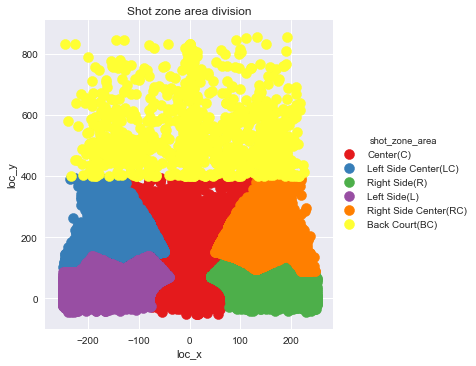

In [9]:
g = sns.FacetGrid(dataset, hue="shot_zone_area", palette="Set1", size=5)
g.map(plt.scatter, "loc_x", "loc_y", s=100, linewidth=.5)
plt.title('Shot zone area division')
g.add_legend();

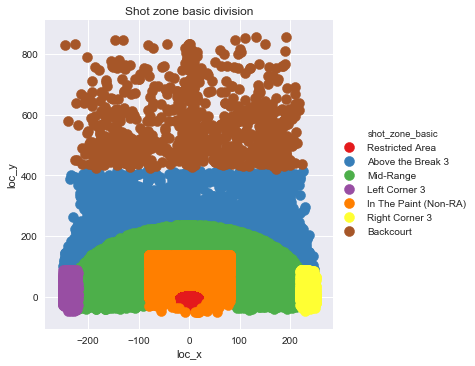

In [14]:
g = sns.FacetGrid(dataset, hue="shot_zone_basic", palette="Set1", size=5) #, hue_kws={"marker": ["", "v"]})
g.map(plt.scatter, "loc_x", "loc_y", s=100, linewidth=.5)
plt.title('Shot zone basic division')
g.add_legend();

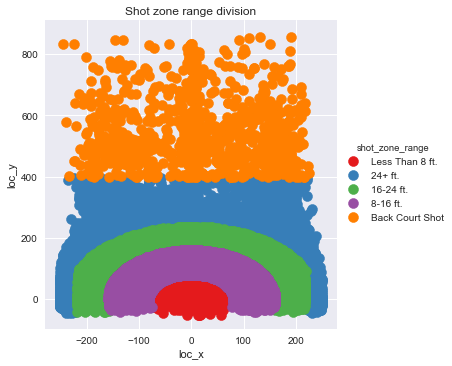

In [10]:
g = sns.FacetGrid(dataset, hue="shot_zone_range", palette="Set1", size=5) #, hue_kws={"marker": ["", "v"]})
g.map(plt.scatter, "loc_x", "loc_y", s=100, linewidth=.5)
plt.title('Shot zone range division')
g.add_legend();

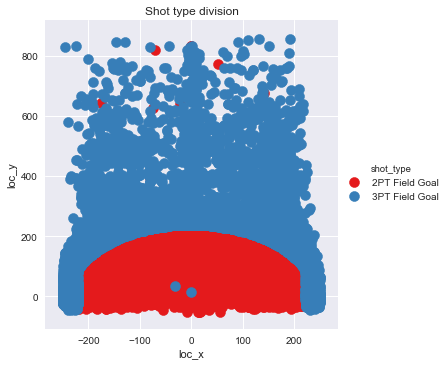

In [13]:
g = sns.FacetGrid(dataset, hue="shot_type", palette="Set1", size=5) #, hue_kws={"marker": ["", "v"]})
g.map(plt.scatter, "loc_x", "loc_y", s=100, linewidth=.5)
plt.title('Shot type division')
g.add_legend();

In [29]:
dataset.head()

,action_type,minutes_remaining,period,seconds_remaining,shot_distance,shot_made_flag,shot_zone_area,loc_x,loc_y,shot_zone_basic,shot_zone_range,shot_type,position,season,is_home
51643,Driving Finger Roll Layup Shot,2,2,20,3,1,Center(C),37,9,Restricted Area,Less Than 8 ft.,2PT Field Goal,Guard,2014,0
149572,Layup Shot,6,2,41,2,1,Center(C),20,11,Restricted Area,Less Than 8 ft.,2PT Field Goal,Guard,2014,1
149573,Jump Shot,6,2,1,3,0,Center(C),32,12,Restricted Area,Less Than 8 ft.,2PT Field Goal,Guard,2014,1
149574,Jump Shot,4,2,44,24,0,Left Side Center(LC),-218,116,Above the Break 3,24+ ft.,3PT Field Goal,Guard,2014,1
149575,Jump Shot,2,2,31,20,0,Center(C),39,197,Mid-Range,16-24 ft.,2PT Field Goal,Guard,2014,1


## Converting all values into categorical in order to run effiecient baysean inference

### Convert distance and zone to numerical

In [30]:
def transdist(value):
    ''' translates distance to bins'''
    distdic = {'Less Than 8 ft.':4.0, '24+ ft.':30, '16-24 ft.':20, '8-16 ft.':12,
       'Back Court Shot':60}
    return distdic[value]

def transzone(value):
    ''' translates zone to bins'''
    distdic = {'Center(C)':0.0, 'Left Side Center(LC)':-1.0, 'Right Side(R)':2.0,
       'Left Side(L)':-2.0, 'Right Side Center(RC)':1.0, 'Back Court(BC)':10}
    return distdic[value]

In [34]:
dataset['distance']=data.shot_zone_range.apply(transdist)
dataset['field_area']=data.shot_zone_area.apply(transzone)

C:\Users\22334\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\22334\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


### Timing feature

In [35]:
def additional_sec(dat):
    add =0
    x = dat['seconds_remaining']
    if x >= 45:
        add=1
    elif x >=15:
        add=0.5
    return dat['minutes_remaining']+add
dataset['time_interval'] = dataset.apply(additional_sec, axis=1)

C:\Users\22334\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


### Filter outlier periods (overtime)

In [36]:
dataset = dataset[dataset.period <=5]

### Label 

In [37]:
dataset.rename(columns={'shot_made_flag' : 'label'}, inplace=True)

### Position

In [38]:
def transpos(position):
    '''transfers position to numeric value (10-50)'''
    dic = {'Guard':15, 'Center':50, 'Forward':40, 'Guard-Forward':22, 'Center-Forward':48,
       'Forward-Center':42, 'Forward-Guard':28}
    return dic[position]

In [39]:
dataset['numpos'] = dataset.position.apply(transpos)

In [40]:
dataset = dataset[['label','distance','field_area','action_type', 'numpos','time_interval','period','season', 'is_home']]

In [41]:
dataset.head()

,label,distance,field_area,action_type,numpos,time_interval,period,season,is_home
51643,1,4.0,0.0,Driving Finger Roll Layup Shot,15,2.5,2,2014,0
149572,1,4.0,0.0,Layup Shot,15,6.5,2,2014,1
149573,0,4.0,0.0,Jump Shot,15,6.0,2,2014,1
149574,0,30.0,-1.0,Jump Shot,15,4.5,2,2014,1
149575,0,20.0,0.0,Jump Shot,15,2.5,2,2014,1


## Divide the data to 80% train for prior calculations

In [42]:
TrainSize=0.8
train=dataset[:int(TrainSize*len(dataset))]
test=dataset[int(TrainSize*len(dataset)):]

# Bayesian Inference

$$ P(A \mid B) = \frac{P(B \mid A) \, P(A)}{P(B)} $$

## auxiliary information

In [15]:
#prior y values and counts - for P(Y=1)
Countall = train.count()[0]
CountY=(int(train.label.sum()),train.label.count()-train.label.sum())
PriorY=CountY[0]*1.0/(Countall)

### count per each evidence what is it's marginal likelihood (saving counts)

In [16]:
# precalculation for knowing P(E) - only counts
ModelEvidence = {}
for evidence in train.columns[1:]:
    ModelEvidence[evidence]=dict(train.groupby(by=evidence).count()['label'])

In [17]:
# precalculation for knowing P(E|H)
EvidencebyY = {}
for evidence in train.columns[1:]:
    pivot = train.groupby(by=['label',evidence],axis=0).count()
    EvidencebyY[evidence]=dict(pivot[pivot.columns[0]])

## Calculation of posterior - update by evidence

In [18]:
def Entropy(P):
    '''calculates entropy of bernuli'''
    return -1.0*(P*min(np.log(P),0)+(1-P)*min(np.log(1-P),0))

In [19]:
def IG(Prior,Posterior):
    ''' Information Gain'''
    return float(Entropy(Prior)-Entropy(Posterior))

In [20]:
def PosteriorCalc(sample):
    '''getting a sample and returns its probability to be positive'''
    PH = PriorY # prior of Y
    PE = {} # prior of evidences
    PEH = {} # likelihood of evidences
    P = PriorY*1.0 # Posterior Calculation
    IGL = [] # list of gradual IG
    FirstIGL=[] # list of IG if the evidence is taken first
    TIG = 0 # total Infromation Gain
    for ev in sample.keys()[1:]:
        try: # error handling while there are no evidences in train
            PE[ev]= ModelEvidence[ev][sample[ev]]*1.0/Countall # without regarding the label
            PEH[ev] = EvidencebyY[ev][(1,sample[ev])]*1.0/CountY[0]
            Post = min(P*PEH[ev]/PE[ev],0.9999) # fixing probabilities >1 because of independence assumption in Naive Bayes
            FirstUpdatePosterior =min(PriorY*PEH[ev]/PE[ev],0.9999) # what would be the P if the evidence is first
            IGL.append(IG(P,Post)) #adding the information gain of gradual update
            FirstIGL.append(IG(PriorY,FirstUpdatePosterior)) #adding the IG if the evidence was the first update
            TIG+=IGL[-1]
            P = Post # Posterior Calculation
        except:P=P
    sample['Prediction'] = P
    sample['TIG'] = TIG
    sample['IGL'] = IGL
    sample['FirstIGL']=FirstIGL
    sample['Best FIG']=sample.keys()[FirstIGL.index(max(FirstIGL))+1]
    return sample

## Apply posterior calculation

In [21]:
test = test.apply(PosteriorCalc,axis=1)

In [29]:
def valid(series,threshold=PriorY):
    '''check if the classification is good under certain threshold'''
    return int(series['label']==round(series['Prediction']+0.5-threshold))

def preddist(series):
    '''per each row - calculate the distance between label and prediction'''
    return abs(series['label']-series['Prediction'])

In [30]:
test['True Classification']=test.apply(valid,axis=1)
test['Classification Distance']= test.apply(preddist,axis=1)

## Prediction results & ROC Plot

In [31]:
test.groupby(by='label').mean()

,distance,field_area,numpos,time_interval,period,season,is_home,Prediction,TIG,True Classification,Classification Distance
label,,,,,,,,,,,
0,17.023524,0.029804,28.911082,5.768318,2.491930,2015,0.494541,0.420556,0.137418,0.655516,0.420556
1,13.013198,-0.001095,30.510206,5.871841,2.464734,2015,0.508843,0.584432,0.229281,0.564494,0.415568


ROC (AUC = 0.656783963551)


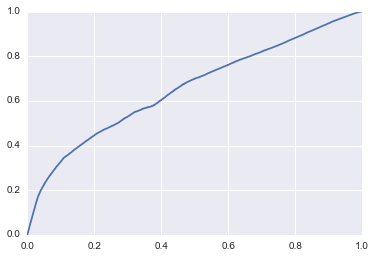

In [32]:
from sklearn.metrics import roc_auc_score, roc_curve
y_true ,y_scores = test.label,  test.Prediction
fpr, tpr, _ = roc_curve(y_true.ravel(), y_scores.ravel())
print 'ROC (AUC = %s)'%roc_auc_score(y_true, y_scores)
ax =plt.plot(fpr, tpr)


## Best Information gain evidence in test

In [22]:
test.groupby('Best FIG' , as_index=False).size()

Best FIG
action_type      55550
distance          7421
field_area        7161
is_home           2511
numpos            3872
period            1881
time_interval     3457
dtype: int64

## Best IG evidence in train (added after clarification)

In [23]:
newtrain = train.apply(PosteriorCalc,axis=1)

In [40]:
newtrain.groupby('Best FIG' , as_index=False).size()

Best FIG
action_type      226815
distance          25550
field_area        23414
is_home           11323
numpos            17247
period             8380
time_interval     14680
dtype: int64

## Total Information Gain Histogram

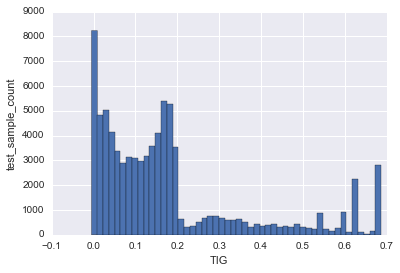

In [52]:
ax = test.TIG.hist(bins=50)
ax.set_xlabel('TIG')
ax.set_ylabel('test_sample_count')

### IG example of distribution over the distance metric - Best information is achieved while throwing from distant point (more likely to miss) or very close

## <font color='red'> Bonus </font> - Finding the correct order of presenting the evidences
### Based on Expected Information Gain <font color='red'> before </font> the update

In [41]:
def EIG(Prior,ev):
    '''Calculate the Expected IG given current Probability and category'''
    Expectation = 0
    for option in ModelEvidence[ev]:
        PE= ModelEvidence[ev][option]*1.0/Countall # without regarding the label
        PEH = EvidencebyY[ev][(1,option)]*1.0/CountY[0]
        Post = min(PEH*Prior/PE,0.999) #Posterior - with fixing impossible cases
        Expectation += float(PE* IG(Prior,Post))
        #print 'PE:',PE,' PEH:', PEH,' IG:',IG(Prior,Prior*PEH/PE),'EX:', Expectation # validation print
    return Expectation      

In [42]:
def MaxEIG(prior,dims):
    ''' Given a prior and list of rellevant dimentions return the best dimention with highest EIG
    Good to calculate as a 1st step (1st evidence selection) and after any update from the rest
    assumes greedy implementation - take the next evidence with highest EIG'''
    res = []
    for ev in dims:
        res.append((EIG(prior,ev),ev))
    res= sorted(res, reverse=True)
    return res

In [43]:
def GradualPosteriorUpdate(sample):
    '''getting a sample and returns its probability to be positive'''
    PH = PriorY # prior of Y
    PE = {} # prior of evidences
    PEH = {} # likelihood of evidences
    P = PriorY*1.0 # Posterior Calculation
    dims = list(sample.keys())[1:]
    TIG = 0 # Total IG
    Bestevorder =[]
    while len(dims)>0:
        ranked = MaxEIG(P,dims)
        ev = ranked[0][1]
        dims.remove(ev)
        Bestevorder.append(ranked[0])
        try:
            PE[ev]= ModelEvidence[ev][sample[ev]]*1.0/Countall # without regarding the label
            PEH[ev] = EvidencebyY[ev][(1,sample[ev])]*1.0/CountY[0]
            #print 'Best Expected IG:',ranked[0], 'real:',IG(P,P*PEH[ev]/PE[ev])
            Post = min(P*PEH[ev]/PE[ev],0.9999) # fixing probabilities >1 because of independence assumption in Naive Baye
            TIG+=IG(P,P*PEH[ev]/PE[ev])
            P =Post # Posterior
        except:
            P=P#*0.5
    sample['Prediction']=P
    sample['TIG'] = TIG
    sample['BestEVorder']=Bestevorder
    return sample
    

## EIG at first interation
#### Same for all data points, since all we know at this point is the prior - sorted evidences by EIG

In [44]:
MaxEIG(PriorY,list(train.columns[1:]))

[(0.05588180979650201, 'action_type'),
 (0.016161000672005592, 'distance'),
 (0.010234898290825113, 'field_area'),
 (0.0020605545647897744, 'numpos'),
 (0.0014772634044231577, 'time_interval'),
 (0.00013729938014109548, 'period'),
 (3.7282211451833934e-05, 'is_home'),
 (1.1897442069434171e-07, 'season')]

## single row example (due to long calculation we won't present for the whole test):

In [46]:
s = train.iloc[855]
s =  GradualPosteriorUpdate(s)

C:\Users\22334\Continuum\Anaconda\lib\site-packages\IPython\kernel\__main__.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\22334\Continuum\Anaconda\lib\site-packages\IPython\kernel\__main__.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\22334\Continuum\Anaconda\lib\site-packages\IPython\kernel\__main__.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [47]:
print s
print 'Best Evidence Presentation order:',list(s.BestEVorder)

label                                                            1
distance                                                        30
field_area                                                       0
action_type                                              Jump Shot
numpos                                                          28
time_interval                                                  3.5
period                                                           4
season                                                        2014
is_home                                                          1
Prediction                                               0.2722202
TIG                                                      0.1027464
BestEVorder      [(0.0558818097965, action_type), (0.0096413280...
Name: 248024, dtype: object
Best Evidence Presentation order: [(0.05588180979650201, 'action_type'), (0.009641328004807825, 'distance'), (0.0044414211648198705, 'field_area'), (0.00103344555858386